In [1]:
import numpy as np
import requests
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.cluster import KMeans
sb.set()

Storing the data from csv file to train dataframe

In [2]:
train = pd.read_csv('metro-trips-2023-q3.csv')
train.head()

C:\Users\asrim\AppData\Local\Temp\ipykernel_11512\2834609296.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('metro-trips-2023-q3.csv')


,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,276590229,1,7/1/2023 0:01,7/1/2023 0:02,4215,34.014309,-118.491341,4215,34.014309,-118.491341,30096,1,Round Trip,Walk-up,electric
1,276590710,16,7/1/2023 0:02,7/1/2023 0:18,4494,34.075981,-118.256012,3031,34.044701,-118.252441,24279,30,One Way,Monthly Pass,electric
2,276613156,148,7/1/2023 0:02,7/1/2023 2:30,4215,34.014309,-118.491341,4215,34.014309,-118.491341,30240,1,Round Trip,Walk-up,electric
3,276590579,3,7/1/2023 0:03,7/1/2023 0:06,4215,34.014309,-118.491341,4215,34.014309,-118.491341,25395,1,Round Trip,Walk-up,electric
4,276613157,146,7/1/2023 0:04,7/1/2023 2:30,4215,34.014309,-118.491341,4215,34.014309,-118.491341,30084,1,Round Trip,Walk-up,electric


Finding the number of empty values

In [3]:
print("Number of null values in end_lat: " + str(train.end_lat.isnull().sum()))
print("Number of null values in end_lon: " + str(train.end_lon.isnull().sum()))

Number of null values in end_lat: 2061
Number of null values in end_lon: 2061


Data Cleaning:


1) Removing of Round Trip data rows
Round Trip dataset is recorded based on the station id, "Round Trip" for trips starting and ending at the same station and "One Way" for all other trips.
Therefore, the rows consisting of Round Trip data will be removed as it does not provide any information on distance


2) Removing of data rows consisting of “Virtual Station”
A "Virtual Station" listed in the checkout and return kiosks, is used by staff to check in or check out a bike remotely for a special event or in a situation in which a bike could not otherwise be checked in or out to a station.
Therefore, the rows consisting of “Virtual Station” data will be removed as it does not provide any information on distance



In [4]:
new_train = train[(train.trip_route_category != 'Round Trip') & (train.end_station != 3000)]
new_train.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
1,276590710,16,7/1/2023 0:02,7/1/2023 0:18,4494,34.075981,-118.256012,3031,34.044701,-118.252441,24279,30,One Way,Monthly Pass,electric
5,276590689,12,7/1/2023 0:04,7/1/2023 0:16,3031,34.044701,-118.252441,3052,34.051102,-118.264557,24682,30,One Way,Monthly Pass,electric
8,276612170,105,7/1/2023 0:17,7/1/2023 2:02,3052,34.051102,-118.264557,4447,34.061600,-118.281990,30126,30,One Way,Monthly Pass,electric
10,276624445,193,7/1/2023 0:27,7/1/2023 3:40,4247,34.033642,-118.291313,3045,34.028511,-118.256668,29972,1,One Way,One Day Pass,electric
11,276590928,26,7/1/2023 0:33,7/1/2023 0:59,4558,34.025688,-118.395302,4568,34.029121,-118.403168,15989,1,One Way,Walk-up,standard


Seeing if there are still empty values

In [5]:
print("Number of null values in end_lat: " + str(new_train.end_lat.isnull().sum()))
print("Number of null values in end_lon: " + str(new_train.end_lon.isnull().sum()))

Number of null values in end_lat: 0
Number of null values in end_lon: 0


we are importing the need library for our next part

In [6]:

from geopy.distance import geodesic

import json
import numpy as np
import requests
import pandas as pd

We need to find distance based on the latitude and longitude provided. So, I am using the geopy to achieve this. Here we are putting the start and stop latitude and longitude into the geopy function and getting the distance back.

In [10]:
point1 = (new_train.iloc[185,5], new_train.iloc[185,6]) # Make sure latitude and longitude are in the correct order
point2 = (new_train.iloc[185,8], new_train.iloc[185,9])

# Calculate the distance
distance = geodesic(point1, point2).kilometers  # or .miles if you prefer

print(f"Distance: {distance} kilometers")

Distance: 13.971778128962603 kilometers


Since the distance is a curved displacement it is not showing the actual distance travelled by an vehical on road. I am using an API and getting the distance. I made an function to do this.

In [11]:
def dis(row):
    x=row.iloc[6]
    y=row.iloc[5]
    z=row.iloc[9]
    w=row.iloc[8]
    
    r=requests.get(f"""http://router.project-osrm.org/route/v1/car/{x},{y};{z},{w}?overview=false""")
    route_1 = json.loads(r.content)["routes"][0]
    return [route_1["distance"]/1000,route_1["duration"]/60]

There is almost 4 km difference from the geopy distance. So, we will be using this to get the distance.

In [12]:
x=dis(new_train.iloc[185])
x

[17.787200000000002, 18.951666666666664]

I am doing an for loop by breaking the data in chunks as without this it might take a very long time to finish doing this. There are more than 100000 rows. Inside the loop I am getting the start and ending lat and long and putting it inside the function to store the distnce in an new distance column.  

In [ ]:
#dont run this
for y in range(70):
    count=y*1000
    for x in range(6750+count,7750+count):
        new_train.iloc[x,[15,16]]=dis(new_train.iloc[x])

After finishing the loop all of the data is stored in the saved.csv file.

In [ ]:
#dont run now
new_train.to_csv('saved.csv')

Our main goal is to predict how long will a person take to reach from 1 station to another. We dont want to find the shortest time to reach, what we want is to give an aproximate time a person from the locality will take to reach their destination. Some might want to just do sight seeing and someone might want to reach very fast, so we are going to club the people based on regions and find their patterns to give an aproxmiate time.

This we be a key feature on the app, so that our customers will find how long they will take to reach and not the shortest time to reach.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
import plotly.express as px
from sklearn.cluster import KMeans
sb.set()

We get back our saved data to analyse

In [3]:
trainData=pd.read_csv('saved.csv')
trainData=trainData.iloc[:,1:]

We think that if we straight try predicting the time for our full data and not by clustering. We should not be able to predict. As some regions might comprise of mainly travelers and another region might be mainly just workers. So we will not be able to give an aproximate time for something that has no patterns.

Intercept of Regression 	: b =  [2.47260311]
Coefficients of Regression 	: a =  [[0.0065649]]



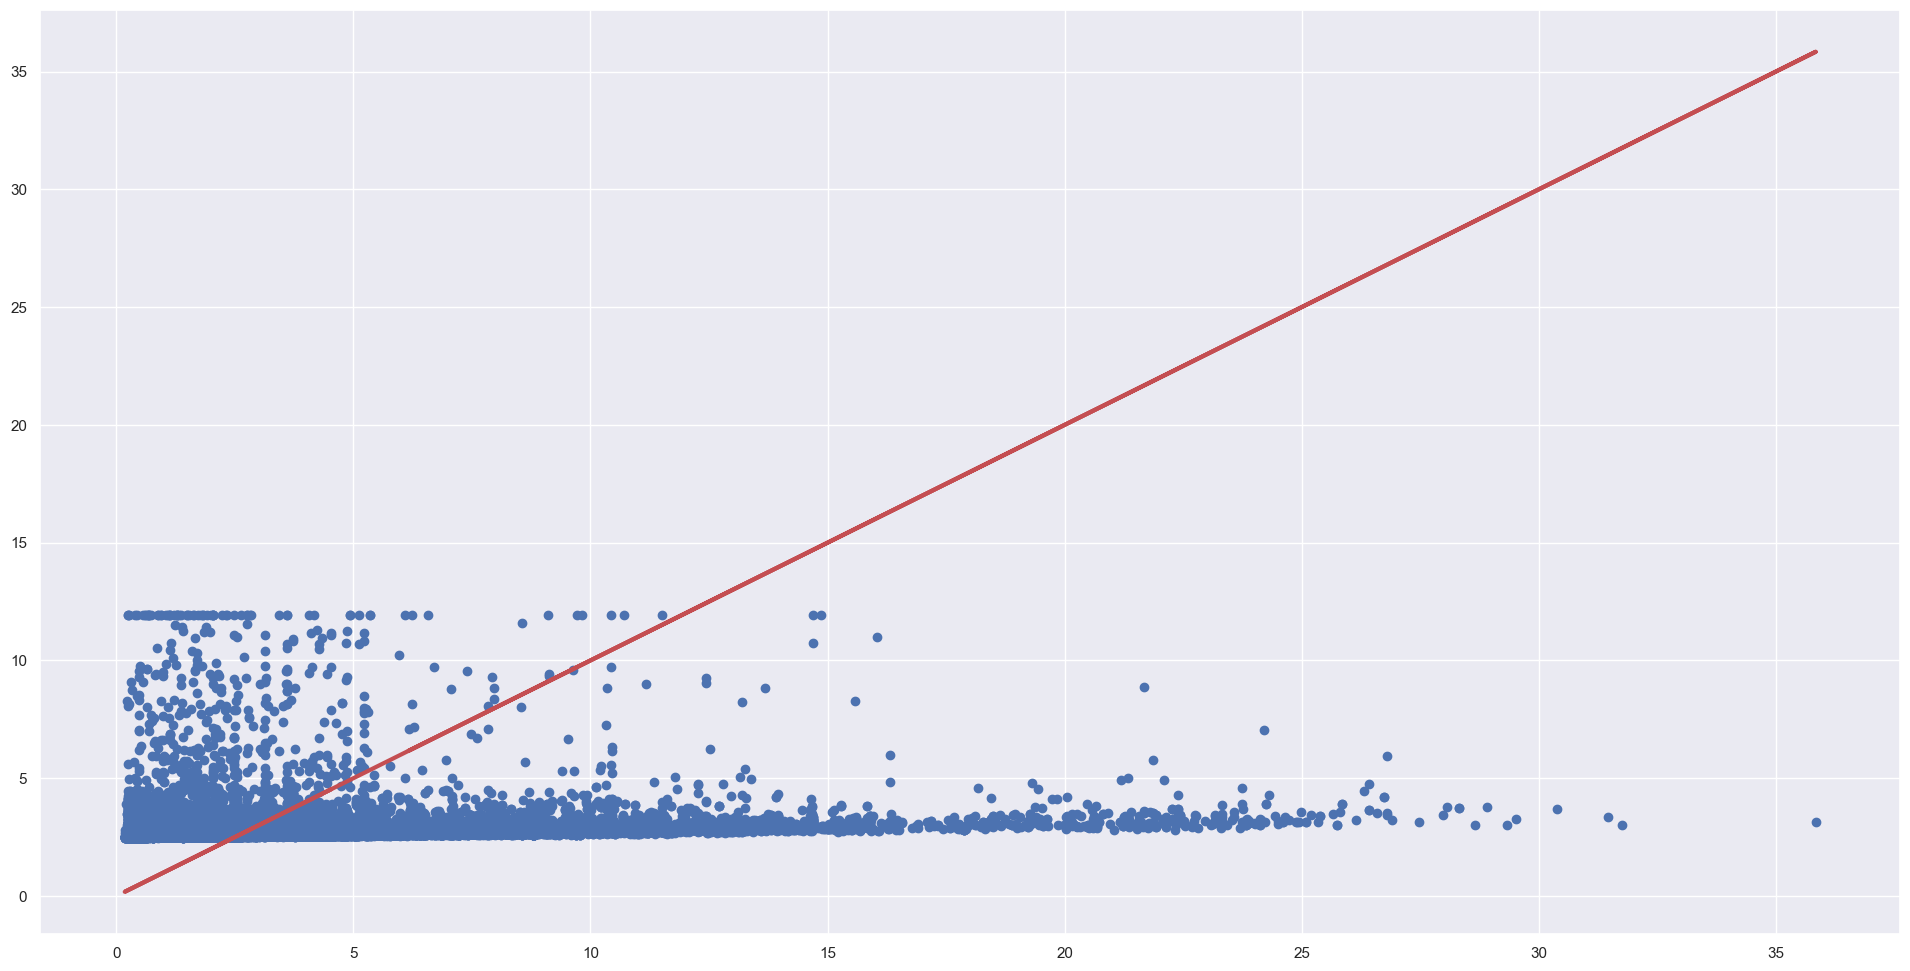

In [15]:
duration = pd.DataFrame(trainData['duration']) #response
distance = pd.DataFrame(trainData['distance']) #predictor

X_train, X_test, y_train, y_test = train_test_split(duration, distance, test_size = 0.20)

linreg = LinearRegression()       
linreg.fit(X_train, y_train)       


print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict SalePrice values corresponding to GrLivArea
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the regression line
f = plt.figure(figsize=(24, 12))
plt.scatter(y_train, y_train_pred, color = "b")
plt.plot(y_train, y_train, 'r-', linewidth = 3)

We can see that the data is spread along the x axis and its not a good data or it dosent have good corelation.

In [16]:
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))

Explained Variance (R^2) 	: 0.035984181859935904


its only able to predict correctly for 0.036 percent of data. this is very bad

In [17]:
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt( mean_squared_error(y_test, y_test_pred)))
print()

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 6.203973376787328
Root Mean Squared Error (RMSE) 	: 2.4907776650651354



I am read another file which has all the station id.

In [18]:
station_info = pd.read_csv('metro-bike-share-stations.csv', encoding='latin1')

I am getting all the latitude and longitude if it exists in the original dataset

In [19]:
real_station=station_info.iloc[1:,:]
list_station=[]
list_unique=trainData.start_station.unique()
for x,y,z in zip(real_station["Latitude"],real_station["Longitude"],real_station["Station_ID"]):
    if(z in list_unique):
        list_station.append([y,x])

In [20]:
id= real_station['Station_ID'].isin(list_unique)
clustering_data=real_station[id]

i am making a dataframe to store only the latitude and longitude

In [21]:
clustering_data=clustering_data.iloc[:,[6,5]]

In [22]:
inertia = []
for n in range(1 , 11):
    model = KMeans(n_clusters = n,
               init='k-means++',
               max_iter=500,
               random_state=42)
    model.fit(clustering_data)
    inertia.append(model.inertia_)

This is called the elbow method to find the best number of clusters

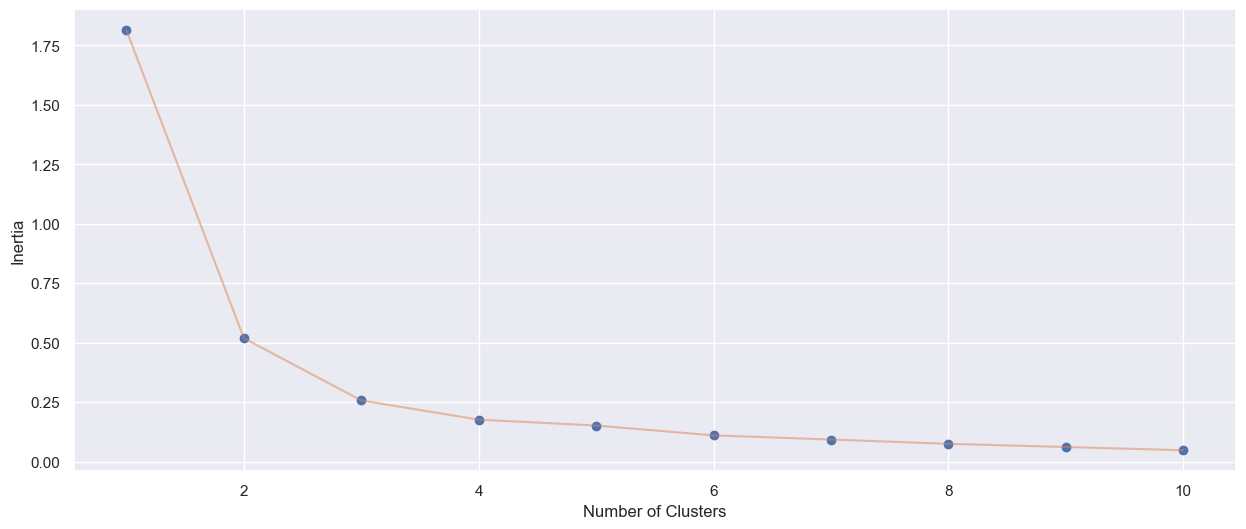

In [23]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

we are seeing how the stations look on the graph

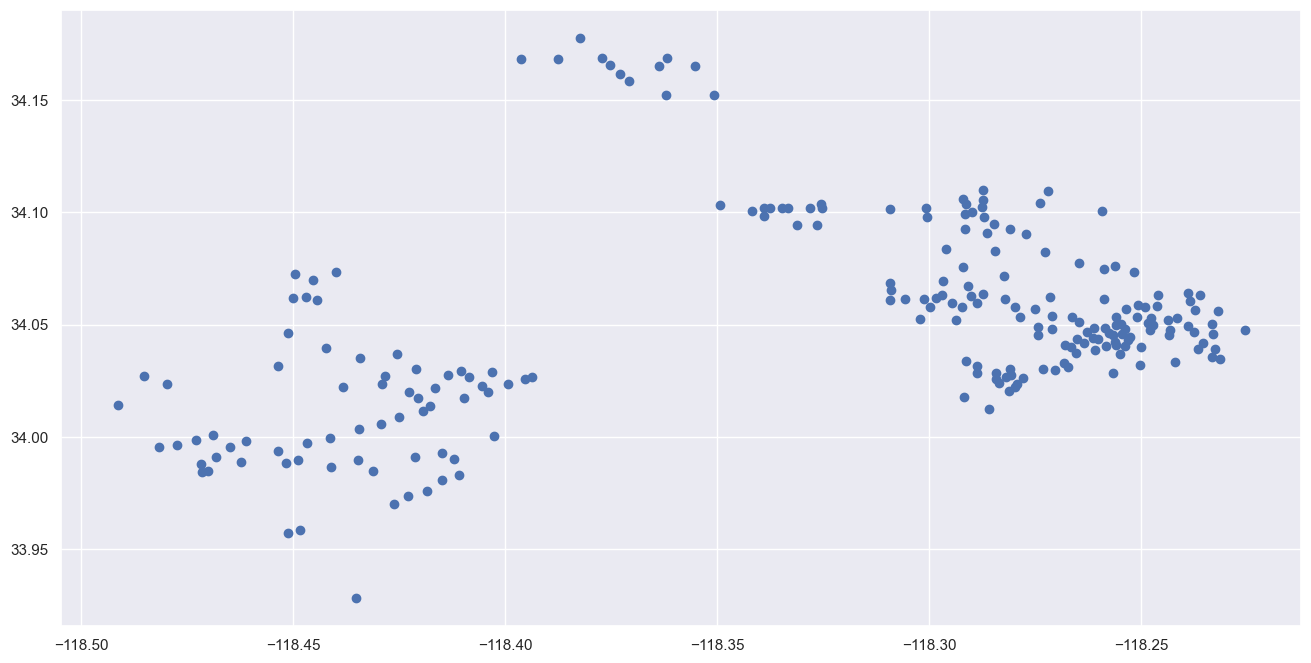

In [24]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = clustering_data.iloc[:,0],y=clustering_data.iloc[:,1])

we are going with number 4

In [25]:
num_clust = 4

kmeans = KMeans(n_clusters= num_clust, n_init=10)

kmeans.fit(clustering_data)

KMeans(n_clusters=4, n_init=10)

it prints the centroid or center value for each cluster 

In [26]:
print("Features", "\tlong", "lat")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()

Features 	long lat

Cluster 0:	-118.26	34.04	
Cluster 1:	-118.44	34.01	
Cluster 2:	-118.37	34.16	
Cluster 3:	-118.3	34.09	


to see how many are there in each cluster

<Axes: xlabel='count', ylabel='Cluster'>

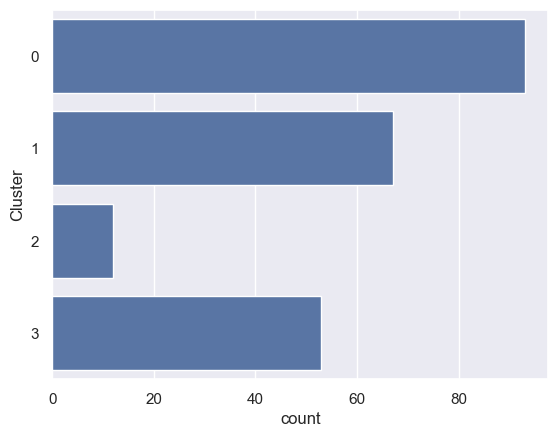

In [27]:
# Predict the Cluster Labels
labels = kmeans.predict(clustering_data)

# Append Labels to the Data
X_labeled = clustering_data.copy()

X_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(X_labeled["Cluster"])

to see how the clustering looks and to see if its good

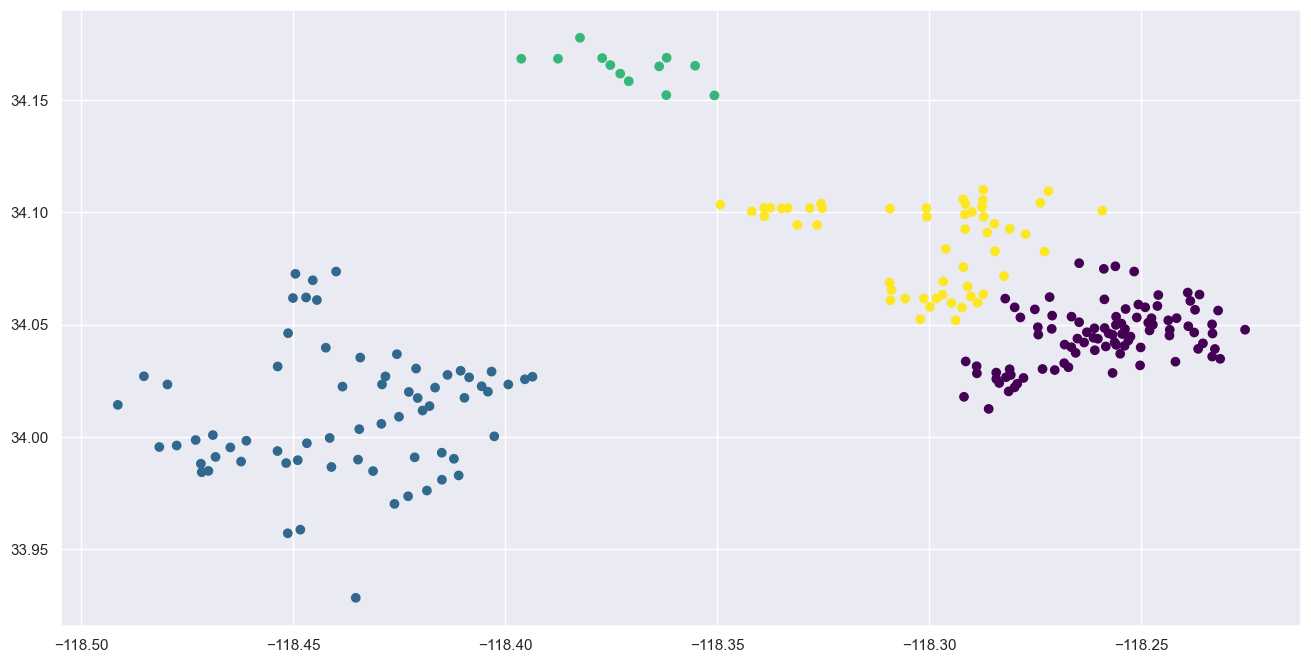

In [28]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "Longitude", y = "Latitude", c = "Cluster", cmap = 'viridis', data = X_labeled)

to split the data based on the clusters

In [29]:
# Create empty dictionary to store dataframes for each cluster
clustered_dataframes = {}

# Iterate over unique cluster labels
for cluster_label in X_labeled["Cluster"].unique():
    # Filter data for the current cluster
    cluster_data = X_labeled[X_labeled["Cluster"] == cluster_label]
    # Store the filtered dataframe in the dictionary
    clustered_dataframes[f"Cluster_{cluster_label}"] = cluster_data


we are combining everything into one

In [30]:
result=pd.concat([clustered_dataframes['Cluster_0'],clustered_dataframes['Cluster_1'],clustered_dataframes['Cluster_2'],clustered_dataframes['Cluster_3']],ignore_index=True)

we are merging this result with out acatual trainData. So that we know what cluster is each ride in

In [31]:
result=result.rename({'Longitude':'start_lon','Latitude':'start_lat'},axis=1)
merged_df = result.merge(trainData, on=['start_lat', 'start_lon'], how='inner')

Now we are spliting the main dataset based on the cluster number

In [32]:
cluster_0=merged_df[merged_df['Cluster']==0]
cluster_1=merged_df[merged_df['Cluster']==1]
cluster_2=merged_df[merged_df['Cluster']==2]
cluster_3=merged_df[merged_df['Cluster']==3]

We are going to do just for 1 cluster to see how it works and to see how good the model will predict. Here we are doing for cluster 1 and we wana see how many outliers are there

In [33]:
duration = pd.DataFrame(cluster_1['duration'])
distance = pd.DataFrame(cluster_1['distance'])
numDF = pd.DataFrame(cluster_1[['distance', 'duration']])
upoutliers_count = numDF.apply(lambda x: len(x[x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))]), axis=0)
looutliers_count = numDF.apply(lambda x: len(x[x < x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25))]), axis=0)

outliers_count=upoutliers_count+looutliers_count
print(outliers_count)

distance    1858
duration    3382
dtype: int64


We are seeing the skewness of the data

In [34]:
skewness=numDF.skew()
print(skewness)

distance     2.222016
duration    10.095805
dtype: float64


the correlation is not very good for the data before removing the outliers

In [35]:
numDF.corr()

,distance,duration
distance,1.000000,0.152725
duration,0.152725,1.000000


making a function FindOutlierBound(df, col) which returns the value of the upperbound for removing the outliers

In [36]:
def FindOutlierBound(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    #print("Lower:", q1 - 1.5 * iqr)
    return q3 + 1.5 * iqr

In [37]:
upper_dis=FindOutlierBound(cluster_1, "distance")
upper_dur=FindOutlierBound(cluster_1, "duration")

We are removing the outliers form cluster 1 and saving it in df_filtered. Then we make distance_Cleaned and duration_cleaned as seperate dataframes

In [38]:
df_filtered =cluster_1[(cluster_1["distance"] <= upper_dis)  & (cluster_1["duration"] <= upper_dur)]

distance_Cleaned = pd.DataFrame(df_filtered['distance'])
duration_Cleaned = pd.DataFrame(df_filtered['duration'])

the correlation is 0.46 and its a big jump from 0.15

<Axes: >

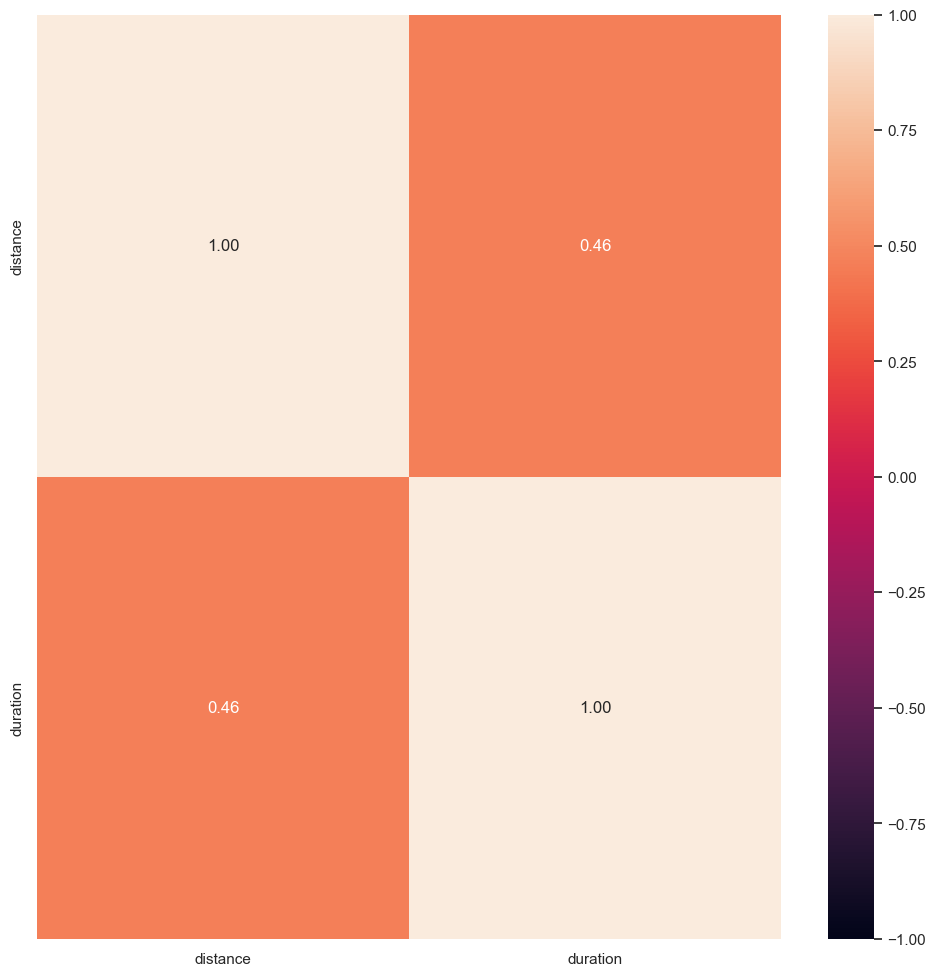

In [39]:
new=pd.DataFrame(df_filtered[['distance', 'duration']])
f = plt.figure(figsize=(12, 12))
sb.heatmap(new.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

we are on seeing the patter for electric bike as speed varies for normal and electric

In [40]:
df_filtered = df_filtered[df_filtered['bike_type'] == 'electric']

I am doing linear regression using xgboost. I am making a function regression_func_xg(predictor, response)

In [41]:
import xgboost as xgb
def regression_func_xg(predictor, response):
    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size=0.20)

    # Convert data into DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Parameters for XGBoost linear regression
    params = {
        'objective': 'reg:squarederror',  # Objective function: linear regression
        'eval_metric': 'rmse'  # Evaluation metric: Root Mean Squared Error
    }

    # Train the model
    num_round = 100
    xgb_model = xgb.train(params, dtrain, num_round)

    # Make predictions
    y_train_pred = xgb_model.predict(dtrain)
    y_test_pred = xgb_model.predict(dtest)

    # Coefficients of the Linear Regression line
    print('Intercept of Regression \t: b = ', xgb_model.get_score(importance_type='weight'))
    print('Coefficients of Regression \t: a = ', xgb_model.get_score(importance_type='gain'))
    print()

    from sklearn.metrics import mean_squared_error,r2_score
    # Calculate R^2 for training and testing sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("Explained Variance (R^2) for training set:", r2_train)
    print("Explained Variance (R^2) for testing set:", r2_test)

# Calculate MSE for training set
    mse_train = mean_squared_error(y_train, y_train_pred)

    # Calculate MSE for testing set
    mse_test = mean_squared_error(y_test, y_test_pred)

    print("Mean Squared Error (MSE) for training set:", mse_train)
    print("Mean Squared Error (MSE) for testing set:", mse_test)
    f = plt.figure(figsize=(24, 12))
    plt.scatter(y_train, y_train_pred, color = "b")
    plt.plot(y_train, y_train, 'r-', linewidth = 3)


The data is much better than before and the Explained Variance is 0.34 for the train. The accuracy is an issue as the MSE is 187 so, rmse is going to be 13 and the mean for durarion is 22 so it will predict very bad.

Intercept of Regression 	: b =  {'distance': 1948.0}
Coefficients of Regression 	: a =  {'distance': 2610.368408203125}

Explained Variance (R^2) for training set: 0.33586213619314054
Explained Variance (R^2) for testing set: 0.34152027674252083
Mean Squared Error (MSE) for training set: 186.65575093825353
Mean Squared Error (MSE) for testing set: 187.5167520155725


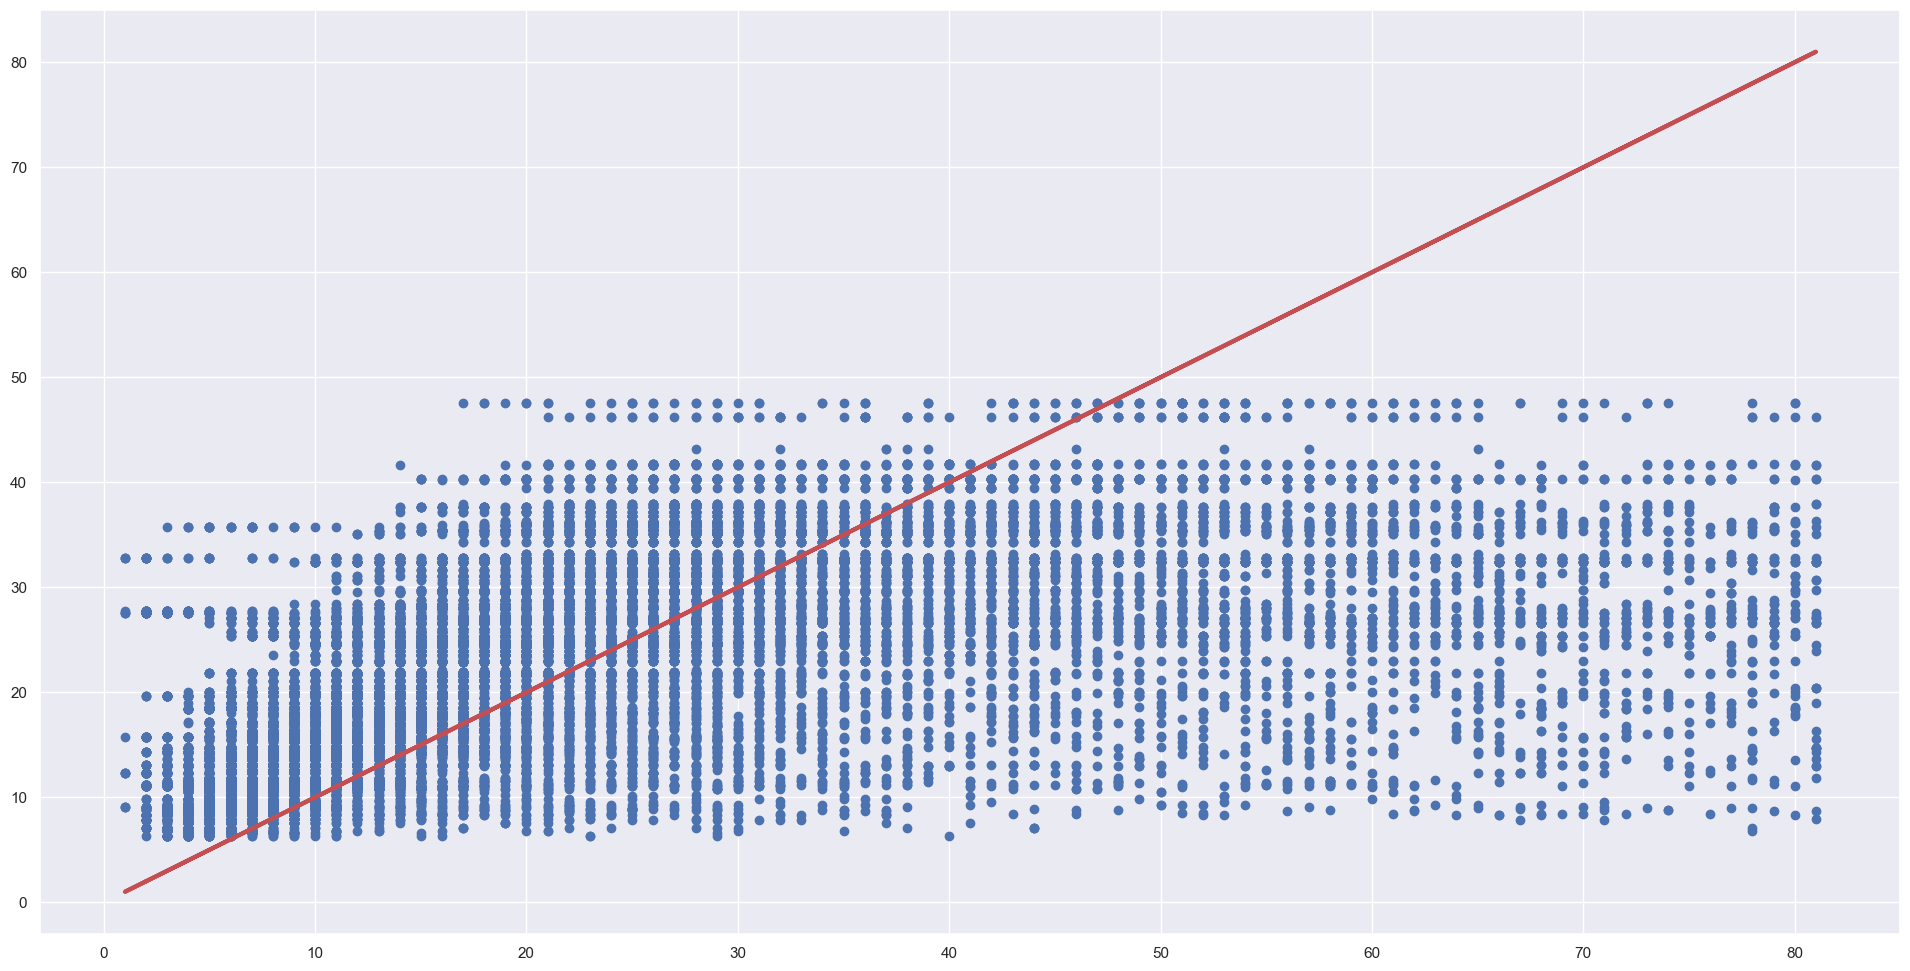

In [42]:
regression_func_xg(distance_Cleaned,duration_Cleaned)

To make the error low I am doing neural network with xgboost. By this way it can learn the data better and predict. I have added learn rate and early stopping so that I dont over fit my data.

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers,optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

def regression_func_nn_xg(predictor_df, response_df):
    # Convert DataFrame to numpy arrays
    predictor = predictor_df.values
    response = response_df.values

    # Normalize predictor and response variables
    scaler = StandardScaler()
    predictor_scaled = scaler.fit_transform(predictor)
    response_scaled = scaler.fit_transform(response.reshape(-1, 1)).flatten()

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor_scaled, response_scaled, test_size=0.20)

    # Define the neural network model
    model = models.Sequential([
        layers.Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1, activation='linear')
    ])

    # Compile the model with an adaptive learning rate optimizer
    optimizer = optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping callback with a reduced patience
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with a dynamic learning rate scheduler
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    lr_schedule = callbacks.LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_schedule], verbose=0)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Print evaluation metrics
    print("Mean Squared Error (MSE) for training set:", mse_train)
    print("Mean Squared Error (MSE) for testing set:", mse_test)
    print("Mean Absolute Error (MAE) for training set:", mae_train)
    print("Mean Absolute Error (MAE) for testing set:", mae_test)
    print("R-squared (Train):", r2_train)
    print("R-squared (Test):", r2_test)

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_train, y_train_pred, color="blue", label="Train predictions vs Actual")
    plt.scatter(y_test, y_test_pred, color="green", label="Test predictions vs Actual")
    plt.plot(y_train, y_train, 'r-', linewidth=2)
    plt.title("Neural Network Regression Results")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

The error rate has droped by al lot. Now we can predict accurately but the variance reduced.



215/215 [==============================] - 0s 1ms/step
Mean Squared Error (MSE) for training set: 0.7645487379621068
Mean Squared Error (MSE) for testing set: 0.7477570876327159
Mean Absolute Error (MAE) for training set: 0.6302814205340938
Mean Absolute Error (MAE) for testing set: 0.6272212350756791
R-squared (Train): 0.23459897426805032
R-squared (Test): 0.2555551063586299


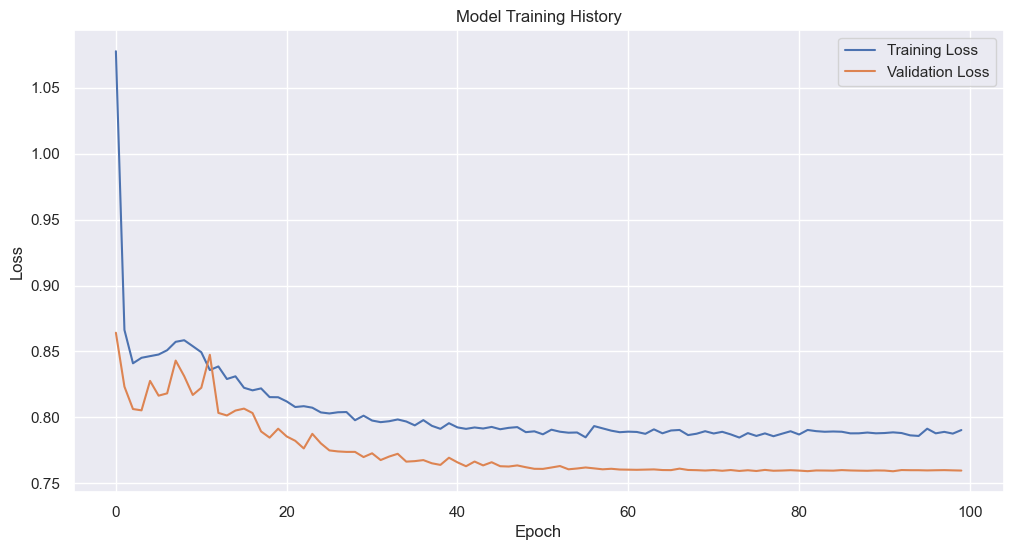

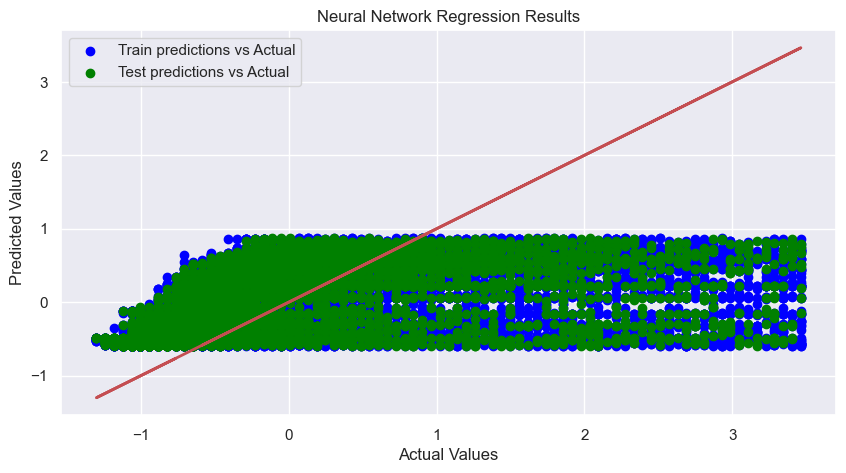

In [44]:
regression_func_nn_xg(distance_Cleaned,duration_Cleaned)

We are doing a polynomial regression instead of linear as the data is quiet broad. So a polynomial regression will be able to predict more accurately. It will also be able to capture the trend even if the data has complex relation. 

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def polynomial_regression_func(predictor, response, degree=2):
    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size=0.20)

    # Polynomial regression with specified degree
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train.reshape(-1, 1), y_train)

    # Coefficients of the Polynomial Regression line
    print('Intercept of Regression \t: b = ', model.named_steps['linearregression'].intercept_)
    print('Coefficients of Regression \t: a = ', model.named_steps['linearregression'].coef_)
    print()

    # Predict values corresponding to predictor
    y_train_pred = model.predict(X_train.reshape(-1, 1))
    y_test_pred = model.predict(X_test.reshape(-1, 1))

    # Calculate Mean Squared Error (MSE)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print("Mean Squared Error (MSE) for training set:\t", mse_train)
    print("Mean Squared Error (MSE) for testing set:\t", mse_test)
    print("Root Mean Squared Error (RMSE) for training set:\t", rmse_train)
    print("Root Mean Squared Error (RMSE) for testing set:\t", rmse_test)

    # Calculate R-squared
    r_squared_train = r2_score(y_train, y_train_pred)
    r_squared_test = r2_score(y_test, y_test_pred)

    print("R-squared (Train):\t", r_squared_train)
    print("R-squared (Test):\t", r_squared_test)

    # Plot the regression line
    f = plt.figure(figsize=(24, 12))
    plt.scatter(X_train, y_train, color="b", label="Training data")
    plt.scatter(X_test, y_test, color="g", label="Testing data")
    plt.plot(X_train, y_train_pred, color="r", label="Predictions")
    plt.xlabel("Predictor")
    plt.ylabel("Response")
    plt.title("Polynomial Regression")
    plt.legend()
    plt.show()

# Example usage:
# polynomial_regression_func(predictor, response, degree=2)


Now our model is able to predict almost 40 percent of the data correctely and its RMSE is 1.5 which is good also as our mean is around 22.

Intercept of Regression 	: b =  [0.30193215]
Coefficients of Regression 	: a =  [[ 0.          0.20541872 -0.00228347]]

Mean Squared Error (MSE) for training set:	 2.3054861592679172
Mean Squared Error (MSE) for testing set:	 2.335372782539493
Root Mean Squared Error (RMSE) for training set:	 1.5183827446556146
Root Mean Squared Error (RMSE) for testing set:	 1.5281926522986207
R-squared (Train):	 0.39356142228243673
R-squared (Test):	 0.39721831144157227


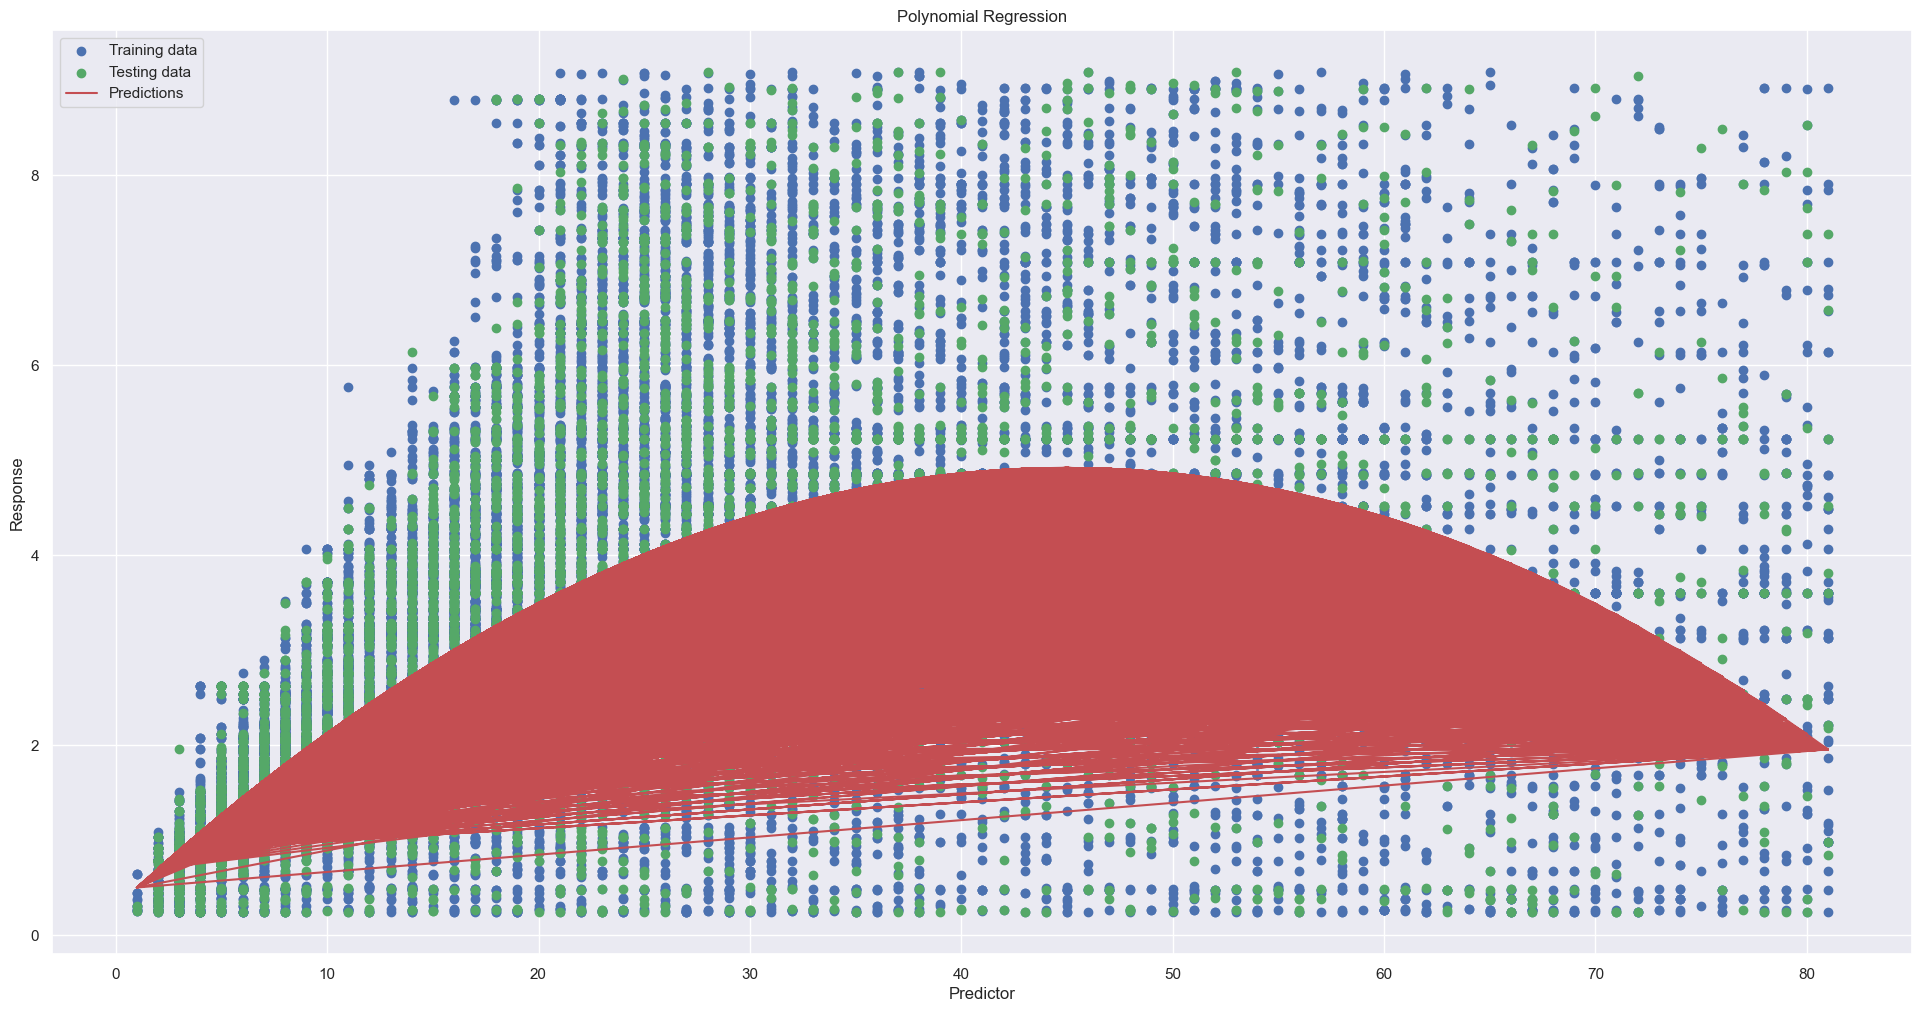

In [46]:
duration_array = duration_Cleaned.to_numpy().reshape(-1, 1)#reshaping it to fit the model
distance_array = distance_Cleaned.to_numpy().reshape(-1, 1)
    
polynomial_regression_func(duration_array, distance_array, degree=2)